In [3]:
import pandas as pd
import numpy as np
import pickle

In [4]:
pd.__version__

'1.4.2'

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [7]:
df_jan_2023 = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')
df_feb_2023 = pd.read_parquet('./data/yellow_tripdata_2023-02.parquet')

In [8]:
df = df_jan_2023

In [9]:
# df.head()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [11]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime

# print(df['duration'].dtype)
# print(type(df['duration'].iloc[0]))

In [12]:
df['duration'].describe()

count                      3066766
mean     0 days 00:15:40.139710039
std      0 days 00:42:35.661074517
min              -1 days +23:30:48
25%                0 days 00:07:07
50%                0 days 00:11:31
75%                0 days 00:18:18
max                6 days 23:09:11
Name: duration, dtype: object

In [13]:
df['duration'] = df['duration'].dt.total_seconds() / 60

In [14]:
# print(df['duration'].dtype)
# print(type(df['duration'].iloc[0]))

In [15]:
# df['duration'] = df.duration.apply(lambda td: td.total_seconds() / 60) #td time delta / not needed

In [16]:
#df = df[df['RatecodeID'] == 5] # Negotiated fare - https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

In [17]:
# df.duration.describe(percentiles=[0.95, 0.98, 0.99])

In [18]:
((df.duration >= 1) & (df.duration <= 60)).mean()

0.9812202822125979

In [19]:
df = df[(df.duration >= 1) & (df.duration <= 60)].copy()
# df['duration'].describe()

In [20]:
categorical = ['PULocationID', 'DOLocationID']

In [21]:
numerical = ['trip_distance']

In [22]:
df[categorical] = df[categorical].astype(str)

In [23]:
# df[caterorical + numerical].iloc[:10].to_dict(orient='records')

In [24]:
# train_dicts = df[caterorical + numerical].to_dict(orient='records')
train_dicts = df[categorical].to_dict(orient='records')

In [25]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [26]:
X_train

<3009173x515 sparse matrix of type '<class 'numpy.float64'>'
	with 6018346 stored elements in Compressed Sparse Row format>

In [27]:
X_train.shape

(3009173, 515)

In [28]:
# dv.feature_names_

In [29]:
target = 'duration'
y_train = df[target].values

In [30]:
y_train

array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
       13.        , 14.4       ])

In [31]:
def clean_dataframe(df, categorical, target):
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df['duration'] = df['duration'].dt.total_seconds() / 60
    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()
    df[categorical] = df[categorical].astype(str)
    
    dicts = df[categorical].to_dict(orient='records')
    y = df[target].values
    return dicts, y

def preprocess(train_df, val_df, categorical, target):
    # Clean both datasets
    train_dicts, y_train = clean_dataframe(train_df, categorical, target)
    val_dicts, y_val = clean_dataframe(val_df, categorical, target)
    
    # Fit vectorizer on training only
    dv = DictVectorizer()
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    return X_train, y_train, X_val, y_val, dv


In [32]:
X_train, y_train, X_val, y_val, dv = preprocess(df_jan_2023, df_feb_2023, categorical, target)

In [33]:
X_val.shape

(2855951, 515)

In [34]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [35]:
y_pred_train = model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print("RMSE on train:", round(rmse_train, 2))

RMSE on train: 7.65


/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


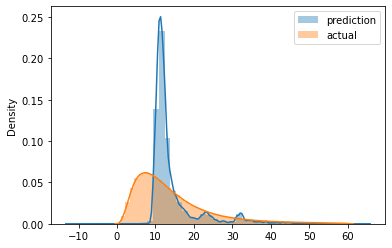

In [39]:
sns.distplot(y_pred_train, label='prediction')  #displot
sns.distplot(y_train, label='actual')
plt.legend()

In [41]:
import os
os.makedirs('models', exist_ok=True)

with open('models/lin_reg.bin', 'wb') as f_out: 
    pickle.dump((dv, model), f_out)

In [37]:
y_pred_val = model.predict(X_val)
rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)
print("RMSE on validation:", round(rmse_val, 2))

RMSE on validation: 7.81


Lasso
- 0.01: Example
